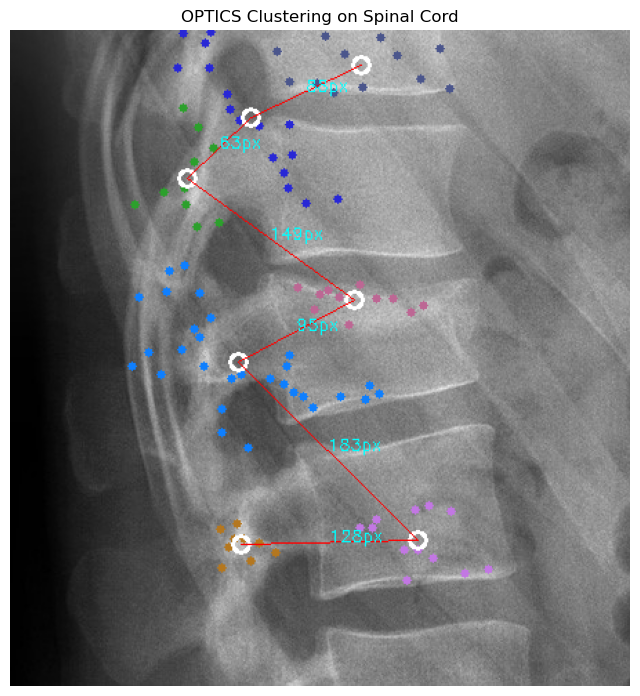

True

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from scipy.spatial.distance import euclidean

# Load and preprocess image
image_path = '/Users/abubakr/Downloads/Spinal Cord Wedge Shape Plain.jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge detection
edges = cv2.Canny(gray, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract centroids of contours
points = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M['m00'] > 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        points.append([cx, cy])
points = np.array(points)

# Apply OPTICS clustering
optics = OPTICS(min_samples=2, xi=0.05, min_cluster_size=0.05)
labels = optics.fit_predict(points)

# Prepare visualization
output = image.copy()
unique_labels = sorted(set(labels))  # Sort for consistent coloring
base_cmap = plt.colormaps.get_cmap("tab10")
color_list = [base_cmap(i % 10) for i in range(len(unique_labels))]

cluster_centers = []
for label in unique_labels:
    if label == -1:
        continue  # Skip noise
    cluster_points = points[labels == label]
    center = np.mean(cluster_points, axis=0).astype(int)
    cluster_centers.append(center)
    color = color_list[label % len(color_list)]
    for pt in cluster_points:
        cv2.circle(output, tuple(pt), 3, (
            int(color[0] * 255),
            int(color[1] * 255),
            int(color[2] * 255)
        ), -1)
    cv2.circle(output, tuple(center), 6, (255, 255, 255), 2)

# Sort centers vertically and calculate distances
cluster_centers.sort(key=lambda x: x[1])  # Sort by y-coordinate
for i in range(len(cluster_centers) - 1):
    pt1 = tuple(cluster_centers[i])
    pt2 = tuple(cluster_centers[i + 1])
    dist = euclidean(pt1, pt2)
    mid_x = (pt1[0] + pt2[0]) // 2
    mid_y = (pt1[1] + pt2[1]) // 2
    cv2.line(output, pt1, pt2, (0, 0, 255), 1)
    cv2.putText(output, f"{int(dist)}px", (mid_x, mid_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)

# Show final result
plt.figure(figsize=(8, 12))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("OPTICS Clustering on Spinal Cord")
plt.axis('off')
plt.show()

# Optional: Save result
cv2.imwrite("spinal_cord_optics_clusters.png", output)


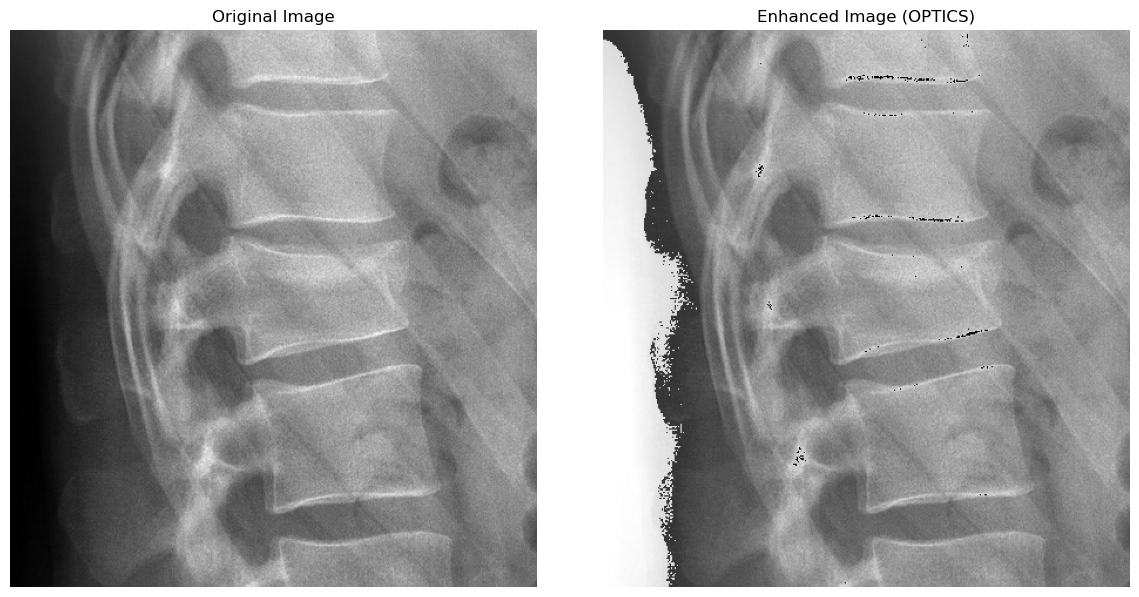

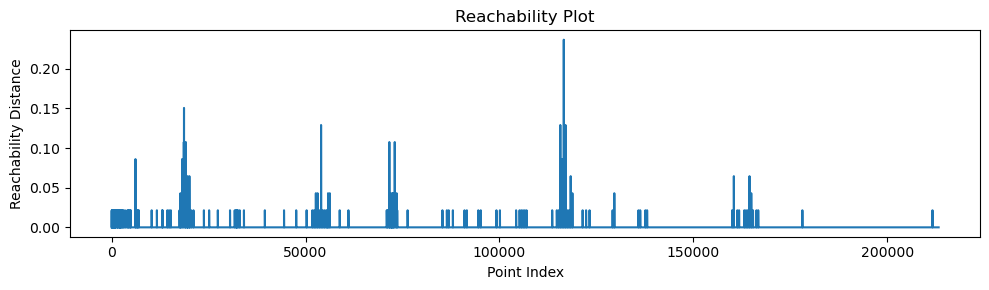

Enhanced image saved to: /Users/abubakr/Downloads/Spinal Cord Wedge Shape Plain_enhanced.jpg


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler
import warnings
import os

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or path is incorrect")
    return img

def preprocess_image(img):
    img_flat = img.flatten().reshape(-1, 1)
    scaler = StandardScaler()
    img_scaled = scaler.fit_transform(img_flat)
    
    # Add small epsilon to avoid zero reachability issues
    img_scaled += 1e-8  
    return img_scaled, scaler

def apply_optics(data, min_samples=50, xi=0.05):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        optics = OPTICS(min_samples=min_samples, xi=xi)
        labels = optics.fit_predict(data)
        return labels, optics

def reconstruct_image(labels, shape):
    unique_labels = np.unique(labels)
    reconstructed = np.zeros(labels.shape, dtype=np.uint8)
    
    min_label = min(unique_labels[unique_labels != -1]) if any(unique_labels != -1) else 0
    max_label = max(unique_labels[unique_labels != -1]) if any(unique_labels != -1) else 1

    for label in unique_labels:
        if label == -1:
            reconstructed[labels == label] = 0  # noise
        else:
            norm_label = (label - min_label) / (max_label - min_label + 1e-8)
            intensity = 50 + int(200 * norm_label)
            reconstructed[labels == label] = intensity

    return reconstructed.reshape(shape)

def plot_reachability(optics_model):
    plt.figure(figsize=(10, 3))
    plt.title("Reachability Plot")
    plt.plot(optics_model.reachability_)
    plt.xlabel("Point Index")
    plt.ylabel("Reachability Distance")
    plt.tight_layout()
    plt.show()

def enhance_medical_image(path, save_output=False):
    original_img = load_image(path)
    data, scaler = preprocess_image(original_img)

    labels, optics_model = apply_optics(data, min_samples=50, xi=0.05)

    # Handle all-noise condition
    if np.all(labels == -1):
        print("Warning: All points classified as noise. Try adjusting min_samples or xi.")
    
    enhanced_img = reconstruct_image(labels, original_img.shape)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Enhanced Image (OPTICS)")
    plt.imshow(enhanced_img, cmap='gray')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Optional: Plot reachability for diagnostics
    plot_reachability(optics_model)

    # Optional: Save output
    if save_output:
        out_path = os.path.splitext(path)[0] + "_enhanced.jpg"
        cv2.imwrite(out_path, enhanced_img)
        print(f"Enhanced image saved to: {out_path}")

    return enhanced_img

# === RUNNING THE SCRIPT ===
if __name__ == "__main__":
    image_path = "/Users/abubakr/Downloads/Spinal Cord Wedge Shape Plain.jpg"  # Replace with your image path
    enhance_medical_image(image_path, save_output=True)
